<a href="https://colab.research.google.com/github/Vyshnavijulapelly/Reinforcement-Learning/blob/main/RL_Lab_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Episode 10	Return: 13.0	Average(100): 17.70


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Episode 20	Return: 22.0	Average(100): 18.35
Episode 30	Return: 19.0	Average(100): 20.17
Episode 40	Return: 20.0	Average(100): 23.88
Episode 50	Return: 31.0	Average(100): 28.44
Episode 60	Return: 31.0	Average(100): 30.40
Episode 70	Return: 42.0	Average(100): 33.61
Episode 80	Return: 22.0	Average(100): 36.29
Episode 90	Return: 58.0	Average(100): 41.82
Episode 100	Return: 124.0	Average(100): 44.93
Episode 110	Return: 66.0	Average(100): 51.35
Episode 120	Return: 53.0	Average(100): 59.90
Episode 130	Return: 38.0	Average(100): 61.55
Episode 140	Return: 47.0	Average(100): 62.12
Episode 150	Return: 44.0	Average(100): 62.39
Episode 160	Return: 83.0	Average(100): 65.21
Episode 170	Return: 140.0	Average(100): 70.81
Episode 180	Return: 159.0	Average(100): 88.46
Episode 190	Return: 29.0	Average(100): 92.69
Episode 200	Return: 31.0	Average(100): 92.27
Episode 210	Return: 109.0	Average(100): 93.60
Episode 220	Return: 286.0	Average(100): 103.97
Episode 230	Return: 255.0	Average(100): 141.07
Episode 24

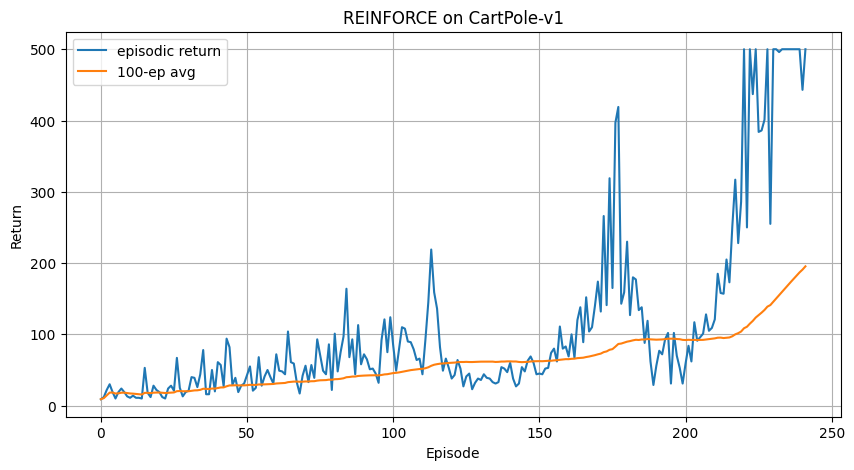

In [2]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

class PolicyNet(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, act_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)

class ValueNet(nn.Module):
    def __init__(self, obs_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

def compute_returns(rewards, gamma):
    R = 0
    returns = []
    for r in reversed(rewards):
        R = r + gamma * R
        returns.append(R)
    returns.reverse()
    return torch.tensor(returns, dtype=torch.float32)

def train(env_name='CartPole-v1', episodes=800, gamma=0.99, lr_policy=1e-3,
          lr_value=1e-3, use_baseline=False, render=False, seed=1):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    env = gym.make(env_name)
    obs, _ = env.reset(seed=seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n

    policy = PolicyNet(obs_dim, act_dim).to(device)
    opt_policy = optim.Adam(policy.parameters(), lr=lr_policy)

    if use_baseline:
        value = ValueNet(obs_dim).to(device)
        opt_value = optim.Adam(value.parameters(), lr=lr_value)
    else:
        value = None

    reward_history = []
    avg_history = []
    best = -float('inf')
    recent = deque(maxlen=100)

    for ep in range(1, episodes + 1):
        obs, _ = env.reset(seed=seed)
        log_probs = []
        rewards = []
        states = []
        done = False
        ep_reward = 0

        while not done:
            state = torch.tensor(obs, dtype=torch.float32, device=device)
            probs = policy(state)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)

            obs, reward, terminated, truncated, _ = env.step(int(action.item()))
            done = terminated or truncated

            log_probs.append(log_prob)
            rewards.append(reward)
            states.append(state)
            ep_reward += reward

        recent.append(ep_reward)
        reward_history.append(ep_reward)
        avg_history.append(np.mean(recent))

        returns = compute_returns(rewards, gamma).to(device)

        if use_baseline:
            states_tensor = torch.stack(states)
            values = value(states_tensor)
            advantages = returns - values.detach()
        else:
            advantages = returns

        policy_loss = torch.stack([-lp * A for lp, A in zip(log_probs, advantages)]).sum()
        opt_policy.zero_grad()
        policy_loss.backward()
        opt_policy.step()

        if use_baseline:
            opt_value.zero_grad()
            value_loss = nn.functional.mse_loss(values, returns)
            value_loss.backward()
            opt_value.step()

        if ep_reward > best:
            best = ep_reward

        if ep % 10 == 0:
            print(f"Episode {ep}\tReturn: {ep_reward:.1f}\tAverage(100): {np.mean(recent):.2f}")

        if np.mean(recent) >= 195.0 and ep >= 100:
            print(f"Environment solved in {ep} episodes! Average return: {np.mean(recent)}")
            break

    env.close()

    plt.figure(figsize=(10,5))
    plt.plot(reward_history, label='episodic return')
    plt.plot(avg_history, label='100-ep avg')
    plt.xlabel('Episode')
    plt.ylabel('Return')
    plt.legend()
    plt.title('REINFORCE on ' + env_name)
    plt.grid(True)
    plt.show()

# Run directly in notebook (no argparse)
train(env_name='CartPole-v1', episodes=500, gamma=0.99, lr_policy=1e-3,
      lr_value=1e-3, use_baseline=True, render=False, seed=1)
